In [1]:
import pandas as pd
import json
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

In [2]:
def renameColumns(df, feature):
    df.columns = ['stationCode', 'measureCode', 'dateTime', feature, 'empty']
    return df.drop(columns=['empty'])

In [3]:
def removeNotWarsaw(df):
    return df[df.stationCode
            .apply(lambda stationCode: stationCode == 352200375)]

In [4]:
def splitDate(df):
    df['month'] = df.apply(
        lambda row: row.dateTime.split('-')[1], axis = 1)
    df['day'] = df.apply(
        lambda row: row.dateTime.split('-')[2][0:2], axis = 1)
    df['hour'] = df.apply(
        lambda row: row.dateTime.split('-')[2][3:5], axis = 1)
    df['minute'] = df.apply(
        lambda row: row.dateTime.split('-')[2][6:8], axis = 1)

In [5]:
def addWeekDay(df):
    df['weekDay'] = df.apply(
        lambda row: 1 + ((int(row['day']) + 2) % 7),
    axis = 1)

In [6]:
def whichDayPart(hour):
    if hour > 2 and hour <= 4:
        return 1
    elif hour > 4 and hour <= 6:
        return 2
    elif hour > 6 and hour <= 8:
        return 3
    elif hour > 8 and hour <= 10:
        return 4
    elif hour > 10 and hour <= 12:
        return 5
    elif hour > 12 and hour <= 14:
        return 6
    elif hour > 14 and hour <= 16:
        return 7  
    elif hour > 16 and hour <= 18:
        return 8
    elif hour > 18 and hour <= 20:
        return 9
    elif hour > 20 and hour <= 22:
        return 10 
    else:
        return 0

In [11]:
def prepareWeatherDF(file, name):
    dfToCut = pd.read_csv(file, header = None, delimiter = ';')
    df = renameColumns(dfToCut, name)
    df = removeNotWarsaw(df)
    splitDate(df)
    df = df.astype({'month': 'int64'})
    df = df.astype({'day': 'int64'})
    df = df.astype({'hour': 'int64'})
    df['dayPart'] = df.apply(
        lambda row: whichDayPart(row['hour']), axis = 1)
    df[name] = df[name].apply(
        lambda data: float(data.replace(',', '.')) if type(data) != float else data)
    return df

In [12]:
dfTemp = prepareWeatherDF('data\meteo\B00300S_2018_03.csv', 'temp')
dfWind = prepareWeatherDF('data\meteo\B00702A_2018_03.csv', 'wind')
dfRain = prepareWeatherDF('data\meteo\B00606S_2018_03.csv', 'rain')

In [13]:
fileList = glob.glob("data\\rowery\\201803*.json")

In [14]:
df = pd.DataFrame(columns = ['month', 'day', 'hour', 'minute', 'rentBikes'])  
for fileName in fileList:
    if os.path.getsize(fileName) > 10000:
        with open(fileName, 'r') as json_file:
            data = json.load(json_file)
        df2 = pd.DataFrame([[
            fileName.split('\\')[2][4:6],
            fileName.split('\\')[2][6:8],
            fileName.split('\\')[2][9:11],
            fileName.split('\\')[2][11:13],
            int(data[0]['region_info']['set_point_bikes']) - int(data[0]['region_info']["available_bikes"])
        ]], columns = ['month', 'day', 'hour', 'minute', 'rentBikes'])
        df = df.append(df2) 

In [15]:
df

,month,day,hour,minute,rentBikes
0,03,04,00,00,187
0,03,04,00,10,179
0,03,04,00,20,179
0,03,04,00,40,177
0,03,04,00,50,177
...,...,...,...,...,...
0,03,31,23,10,528
0,03,31,23,20,528
0,03,31,23,30,525
0,03,31,23,40,525


In [16]:
addWeekDay(df)
df = df.astype({'month': 'int64'})
df = df.astype({'day': 'int64'})
df = df.astype({'hour': 'int64'})
df = df.astype({'minute': 'int64'})
df = df.astype({'rentBikes': 'float'})
df['dayPart'] = df.apply(
    lambda row: whichDayPart(row['hour']), axis = 1)

In [17]:
df['prevRent'] = df.apply(
    lambda row: np.mean(df.loc[df['day'] == row['day'] - 7]['rentBikes']) if row['day'] > 10 else 0,
axis = 1)

In [18]:
df['temp'] = df.apply(
   lambda row: round(np.mean(dfTemp.loc[dfTemp['month'] == row['month']].loc[dfTemp['day'] == row['day']].loc[dfTemp['dayPart'] == row['dayPart']]['temp']), 2),
axis = 1)

In [19]:
df['rain'] = df.apply(
   lambda row: np.mean(dfRain.loc[dfRain['month'] == row['month']].loc[dfRain['day'] == row['day']].loc[dfRain['dayPart'] == row['dayPart']]['rain']),
axis = 1)

In [20]:
df['wind'] = df.apply(
   lambda row: round(np.mean(dfWind.loc[dfWind['month'] == row['month']].loc[dfWind['day'] == row['day']].loc[dfWind['dayPart'] == row['dayPart']]['wind']), 2),
axis = 1)

In [21]:
df.head(50)

,month,day,hour,minute,rentBikes,weekDay,dayPart,prevRent,temp,rain,wind
0,3,4,0,0,187.0,7,0,0.0,-10.67,0.0,2.26
0,3,4,0,10,179.0,7,0,0.0,-10.67,0.0,2.26
0,3,4,0,20,179.0,7,0,0.0,-10.67,0.0,2.26
0,3,4,0,40,177.0,7,0,0.0,-10.67,0.0,2.26
0,3,4,0,50,177.0,7,0,0.0,-10.67,0.0,2.26
0,3,4,1,0,199.0,7,0,0.0,-10.67,0.0,2.26
0,3,4,1,10,201.0,7,0,0.0,-10.67,0.0,2.26
0,3,4,1,20,201.0,7,0,0.0,-10.67,0.0,2.26
0,3,4,1,30,201.0,7,0,0.0,-10.67,0.0,2.26
0,3,4,1,40,190.0,7,0,0.0,-10.67,0.0,2.26


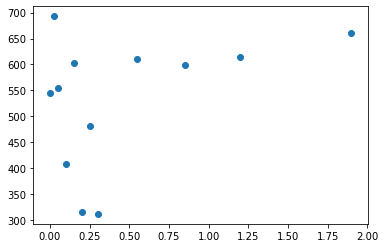

In [22]:
weekDayMean = df.groupby('rain').mean()['rentBikes']
plt.scatter(weekDayMean.index.values, weekDayMean.values)

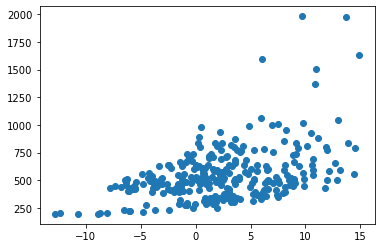

In [23]:
weekDayMean = df.groupby('temp').mean()['rentBikes']
plt.scatter(weekDayMean.index.values, weekDayMean.values)

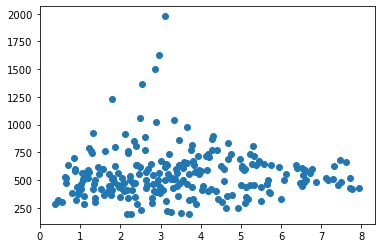

In [24]:
weekDayMean = df.groupby('wind').mean()['rentBikes']
plt.scatter(weekDayMean.index.values, weekDayMean.values)

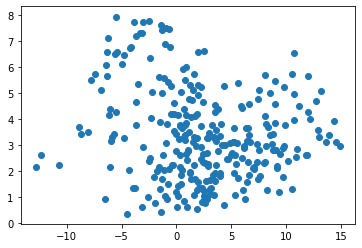

In [25]:
weekDayMean = df.groupby('temp').mean()['wind']
plt.scatter(weekDayMean.index.values, weekDayMean.values)

In [26]:
df = df.dropna()

In [27]:
df = df[np.abs(df.rain-df.rain.mean()) <= (3*df.rain.std())]

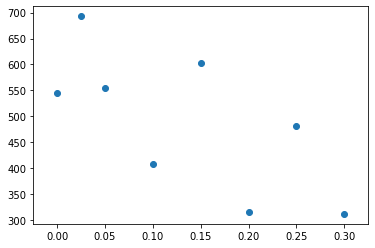

In [28]:
weekDayMean = df.groupby('rain').mean()['rentBikes']
plt.scatter(weekDayMean.index.values, weekDayMean.values)

In [29]:
x = df[['weekDay', 'dayPart', 'temp', 'rain', 'wind', 'hour', 'prevRent']]
y = df['rentBikes']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)

In [30]:
poly = PolynomialFeatures(4)
X_train = poly.fit_transform(x_train)
X_test = poly.fit_transform(x_test)
X_valid = poly.fit_transform(x_valid)
X = poly.fit_transform(x)

In [31]:
regr = linear_model.LinearRegression(normalize = True)
regr.fit(X_train,y_train)
y_pred_train = regr.predict(X_train)
y_pred_valid = regr.predict(X_valid)

In [32]:
print(sklearn.metrics.mean_absolute_error(y_train, y_pred_train))
print(sklearn.metrics.r2_score(y_train, y_pred_train))
print(sklearn.metrics.mean_absolute_error(y_valid, y_pred_valid))
print(sklearn.metrics.r2_score(y_valid, y_pred_valid))

40.22941666612739
0.9321134954866758
45.565794268994374
0.9251597278964622


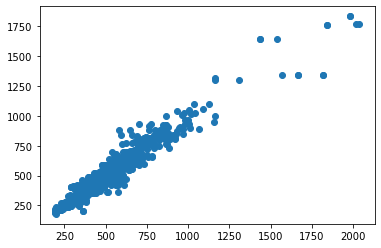

In [33]:
plt.scatter(y_valid, y_pred_valid)

In [34]:
y_pred_test = regr.predict(X_test)
print(sklearn.metrics.mean_absolute_error(y_test, y_pred_test))
print(sklearn.metrics.r2_score(y_test, y_pred_test))

44.79482915900731
0.9226386672393241
